# Exploratory Data Analysis 🍃

The goal of this EDA is to understand the different leaf datasets available in the `data` folder. This would be partially exploratory in the real sense but we shall also define some objectives of things we're looking for.

### Kaggle Data Issues 💩

* `Bael` has missing healthy images and `Basil` has missing diseased images.
    * Upon visual inspection the leaves look similar. We are going to assume both are `Basil`. 
    * Rename subdir name from `Bael diseased (P4b)` to `Basil diseased (P8b)` 
        
* `Arjun` and `Alstonia Scholaris` subdirectories had `P1b` for healthy files and `P1a` for diseased files. 
    * This is inconsistent with the rest of the naming convention. 
    * Subdirectories have been renamed to match
        
* `Alstonia Scholaris`, upon visual inspection seems like healthy files are listed under the diseased sub-driectory and vice versa. 
    * Swapped location of select files. 

Dependencies:
* This notebook is run within the `leafydex` anaconda environment described in the [README](https://github.com/cricksmaidiene/leafydex/blob/main/README.md) file
* Data available within `/data` directory of project root folder
* `compress.py` created compressed images of different photos

## Table of Contents 📇

```yaml
1. Leaf Disease Dataset
    1.1 Create Metadata DataFrame
    1.2 Descriptive Statistics
    1.3 Image Samples
        1.3.1 Species Samples
        1.3.2 Disease & Non-Disease Pairs
    1.4 Decisions
    1.5 Sampling & Quantization
        1.5.1 Histogram Equalization
        1.5.2 Contrast Stretching
        1.5.3 Edge Detection
        1.5.4 Function Composition
    1.6 Object Detection
        1.6.1 Binary Threshold (Manual)
        1.6.2 Binary Threshold (Auto)
        1.6.3 Color Segmentation
        1.6.4 Image Dilation
    1.7 Color Study
```

In [1]:
import math
import os
import warnings
from typing import Callable, Literal

import cv2
import inflection
import numpy as np
import pandas as pd
import plotly.express as px
import scipy
import seaborn as sns
import skimage
from matplotlib import pyplot as plt
from PIL import Image
from pyprojroot import here
from skimage.io import imshow
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings("ignore")

%matplotlib inline

sns.set_theme()

---

## 1. Leaf Disease Dataset 🤒

[![](https://img.shields.io/badge/Kaggle-20BEFF.svg?style=for-the-badge&logo=Kaggle&logoColor=white)](https://www.kaggle.com/datasets/csafrit2/plant-leaves-for-image-classification)


* The dataset from kaggle contains images of leaves from 11 species of trees such as `lemon`, `mango`, and `pomegranite`. 
* A total of `4503` jpeg image files at `6k X 4k RGB pixel resolution`
* `2273` healthy leaves and `2221` diseased leaves. 
* The dataset comes decomposed into training, testing, validation, and prediction images, therefore our EDA and model building will not further segregate data into training and other sets. 

In [2]:
data_dir: str = os.path.join(here(), "data", "raw", "Plants_2_compressed")

### 1.1 Create a Metadata Dataframe ⚙️

* We first iterate through the entire file directory containing the images. 
* The image paths have the following structure
    * `Plants_2_compressed/{data_type}/{species_name} {disease_status} ({code})/{filename}.JPG'`
    * Ex: `Plants_2_compressed/train/Chinar diseased (P11b)/0022_0071.JPG'`
* We then parse out the elements from the paths and create a metadata dataframe to perform summary statistics

In [3]:
image_list: list = []

# do a depth-first-search based walk through the directory tree
for path, directories, files in os.walk(data_dir):
    # if leaf nodes are detected
    if files:
        # iterate through each file
        for img_file in files:
            # get hd and compressed file paths
            cmp_file_abs_path: str = os.path.join(path, img_file)
            path_parts: list[str] = cmp_file_abs_path.split("/")

            data_type: str = path_parts[-3]
            species: str = path_parts[-2]
            img_name: str = path_parts[-1]
            image_list.append((data_type, species, img_name, cmp_file_abs_path))

In [4]:
df: pd.DataFrame = pd.DataFrame(
    data=image_list, columns=["data_type", "name", "file", "path"]
)

# assign diseased tag based on name
df["diseased"] = df["name"].apply(lambda cell: True if "diseased" in cell else False)

# assign species code based on value within paranthesis
df["species_code"] = df["name"].apply(
    lambda cell: cell.split("(")[-1].replace(")", "").strip()
)

# define species name by removing tokens and paranthesized characters
df["species_name"] = df["name"].apply(
    lambda cell: cell.replace("diseased", "")
    .replace("healthy", "")
    .split("(")[0]
    .strip()
)

# remove false name directory of images
df = df[
    ~df["name"].isin(["images to predict", ".ipynb_checkpoints"]).reset_index(drop=True)
]
df.sample(5)

data_type                            name           file  \
3631     train  Pongamia Pinnata healthy (P7a)  0007_0177.JPG   
4432      test           Lemon diseased (P10b)  0021_0002.JPG   
77       train          Chinar diseased (P11b)  0022_0080.JPG   
1001     train            Jamun diseased (P5b)  0017_0139.JPG   
4262     train         Jatropha diseased (P6b)  0018_0036.JPG   

                                                   path  diseased  \
3631  /home/jupyter-eshwaran/mids/207/leafydex/data/...     False   
4432  /home/jupyter-eshwaran/mids/207/leafydex/data/...      True   
77    /home/jupyter-eshwaran/mids/207/leafydex/data/...      True   
1001  /home/jupyter-eshwaran/mids/207/leafydex/data/...      True   
4262  /home/jupyter-eshwaran/mids/207/leafydex/data/...      True   

     species_code      species_name  
3631          P7a  Pongamia Pinnata  
4432         P10b             Lemon  
77           P11b            Chinar  
1001          P5b             Jamun  
4262          P6b          Jatropha

---

### 1.2 Descriptive Statistics 📊

In [5]:
df.describe().transpose().drop(columns=["top"])

count unique  freq
data_type     4494      3  4274
name          4494     22   345
file          4494   4494     1
path          4494   4494     1
diseased      4494      2  2273
species_code  4494     22   345
species_name  4494     11   623

**✏️ Notes: `describe`**
* `4494` total images of `12` species across `22` categorization of `diseased` and `healthy`
* There are `12` species but only `22` healthy / diseased totals. This means two species do not have data for `diseased` or `split`
    * This is a result of incorrect kaggle data

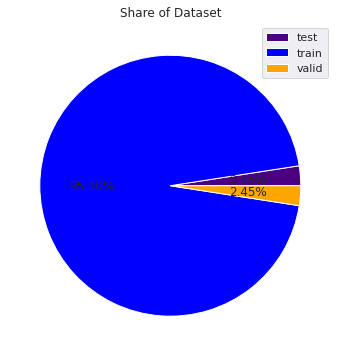

In [6]:
df.groupby(["data_type"]).size().plot(
    kind="pie",
    legend=True,
    title="Share of Dataset",
    colors=["indigo", "blue", "orange"],
    autopct="%1.2f%%",
    figsize=(10, 6),
    labeldistance=None,
);

**✏️ Notes `train-test` split**

* `Training` data takes up too much space, and we may need to consider reorganizing the train-test split

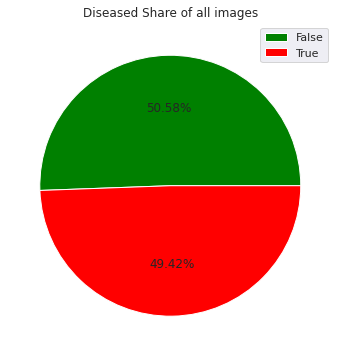

In [7]:
df.groupby(["diseased"]).size().plot(
    kind="pie",
    legend=True,
    title="Diseased Share of all images",
    colors=["green", "red"],
    autopct="%1.2f%%",
    figsize=(10, 6),
    labeldistance=None,
);

**✏️ Notes `diseased-healthy` split**
* The data is evenly spread across all plants between `diseased` and `healthy`. 

However, we must look deeper at the individual species distribution to conclude on any lopsidedness

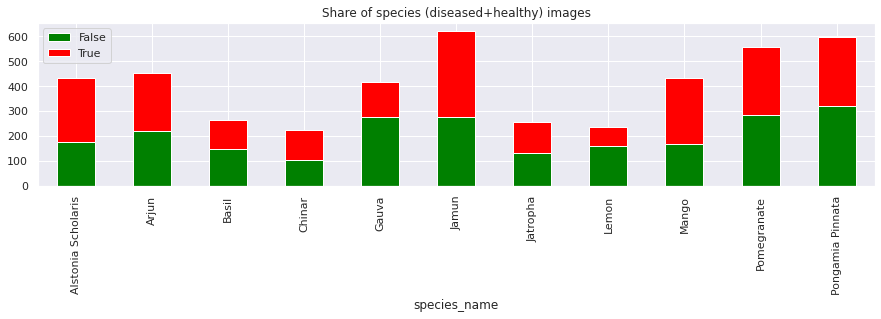

In [8]:
df.groupby(["species_name", "diseased"]).size().unstack().plot(
    kind="bar",
    stacked=True,
    title="Share of species (diseased+healthy) images",
    figsize=(15, 3),
    color=["green", "red"],
    legend=True,
).legend(loc="best");

**✏️ Notes `species disease categorization` split**

* `Lemon` is lopsided on the distribution of `diseased` and `healthy`
* `Jamun` has the most data, and `Basil` has the least

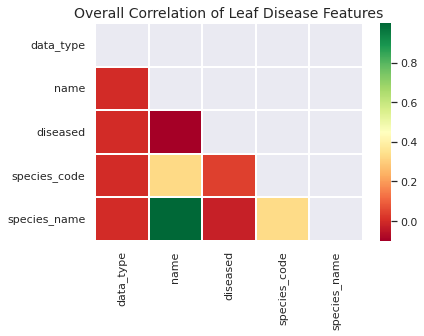

In [9]:
label_encoder: LabelEncoder = LabelEncoder()

categorical_df: pd.DataFrame = pd.DataFrame()

for col in df.drop(columns=["path", "file"]).columns:
    label_encoder.fit(df[col])
    categorical_df[col] = pd.Series(label_encoder.transform(df[col]))

corr: pd.DataFrame = categorical_df.corr()
diag_mask: np.ndarray = np.zeros_like(corr, dtype=np.bool)
diag_mask[np.triu_indices_from(diag_mask)] = True
plt.figure()
plt.title("Overall Correlation of Leaf Disease Features", fontsize=14)

sns.heatmap(
    corr,
    mask=diag_mask,
    annot=False,
    cmap="RdYlGn",
    linewidths=0.2,
    annot_kws={"size": 20},
);

**✏️ Notes**

Nothing out of the ordinary

---

### 1.3 Image Samples 📸
* In this section, we define some utilites to sample the images of leaves directly
* The cells of this section can be re-run to produce a new sample
* We define a function `plot_images_from_metadataframe` that takes a subset of the dataframe and creates a subplot of images

In [17]:
def plot_images_from_metadataframe(
    df: pd.DataFrame,
    path_col: str,
    subplot_rows: int,
    subplot_cols: int,
    title_cols: list[str] = None,
    figsize=(30, 9),
) -> plt.Figure:
    if subplot_rows * subplot_cols < len(df):
        raise ValueError("Subplot matrix does not match size of dataframe")

    if path_col not in df.columns:
        raise ValueError("Path column not found in dataframe")

    fig = plt.figure(figsize=figsize)

    for indx, row in df.iterrows():
        img: Image.Image = Image.open(row.loc[path_col])
        fig.add_subplot(subplot_rows, subplot_cols, indx + 1)
        plt.imshow(img)
        plt.axis("off")
        if title_cols:
            title_str: str = ", ".join(
                [f"{inflection.humanize(c)}: {row.loc[c]}" for c in title_cols]
            )
            plt.title(title_str)

    return plt

#### 1.3.1 Species Sample 🗃
* In this section, we list one image from each species, irrespective of whether or not it is diseased
* This is primarily done to understand the structures of different leaves themselves and notice any similarities

In [18]:
# get one sample from each species
sample_species_df: pd.DataFrame = (
    df.groupby("species_name").apply(lambda x: x.sample()).reset_index(drop=True)
)
print(sample_species_df.shape)
sample_species_df.head(3)

(11, 7)


data_type                              name           file  \
0     train  Alstonia Scholaris healthy (P2a)  0003_0011.JPG   
1     valid              Arjun diseased (P1b)  0013_0005.JPG   
2     train              Basil diseased (P8b)  0016_0069.JPG   

                                                path  diseased species_code  \
0  /home/jupyter-eshwaran/mids/207/leafydex/data/...     False          P2a   
1  /home/jupyter-eshwaran/mids/207/leafydex/data/...      True          P1b   
2  /home/jupyter-eshwaran/mids/207/leafydex/data/...      True          P8b   

         species_name  
0  Alstonia Scholaris  
1               Arjun  
2               Basil

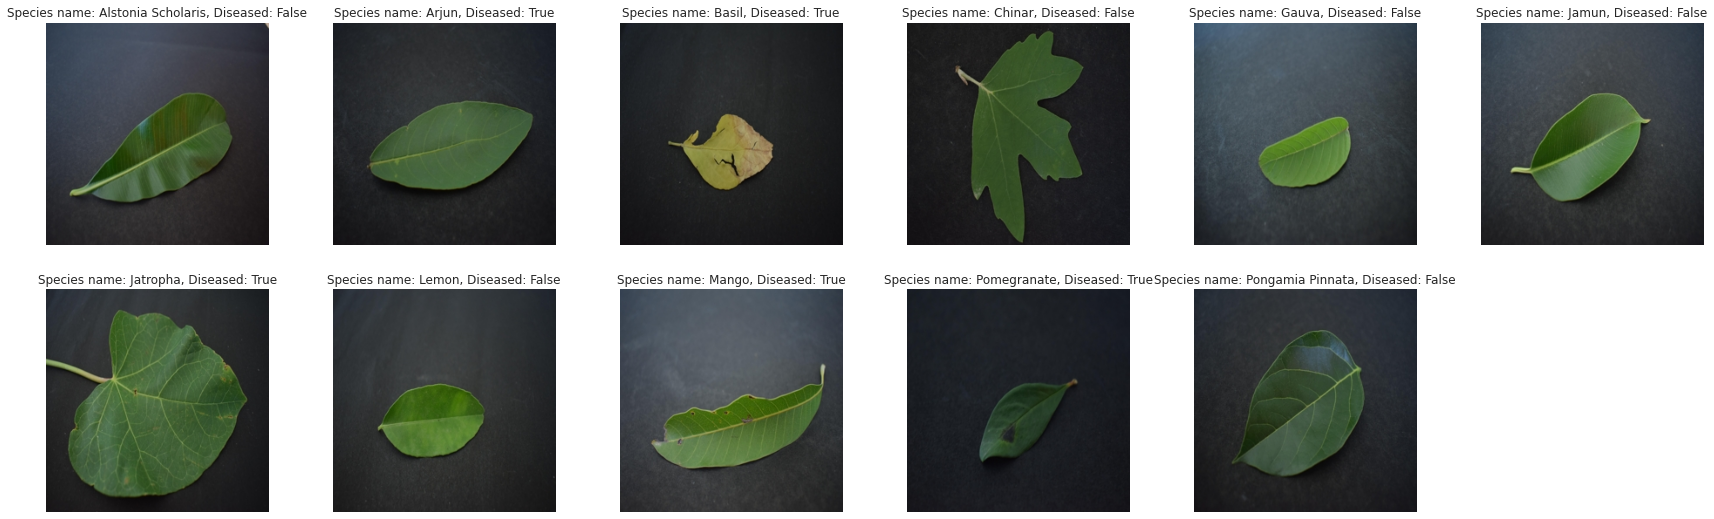

In [19]:
plt: plt.Figure = plot_images_from_metadataframe(
    df=sample_species_df,
    path_col="path",
    subplot_rows=2,
    subplot_cols=6,
    title_cols=["species_name", "diseased"],
)
plt.show()

**✏️ Notes:** 
* `Jatropha` and `Chinar` share the approximate same structure
* `Lemon` with either `Jamun` or `Gauva` could be mistaken without the same zoom level (as a possible model error later on)
* `Arjun` is slightly more curly than `Mango` despite similar structure

#### 1.3.2 Disease & Non-Disease Pairs 🌡
* In this section we create a paired list where we contrast diseased vs non-diseased leaves for the same species

In [20]:
# get one sample from each species
sample_all_df: pd.DataFrame = (
    df.groupby("name").apply(lambda x: x.sample()).reset_index(drop=True)
)
print(sample_all_df.shape)
sample_all_df.head(3)

(22, 7)


data_type                               name           file  \
0     train  Alstonia Scholaris diseased (P2b)  0014_0162.JPG   
1     train   Alstonia Scholaris healthy (P2a)  0003_0174.JPG   
2     train               Arjun diseased (P1b)  0013_0065.JPG   

                                                path  diseased species_code  \
0  /home/jupyter-eshwaran/mids/207/leafydex/data/...      True          P2b   
1  /home/jupyter-eshwaran/mids/207/leafydex/data/...     False          P2a   
2  /home/jupyter-eshwaran/mids/207/leafydex/data/...      True          P1b   

         species_name  
0  Alstonia Scholaris  
1  Alstonia Scholaris  
2               Arjun

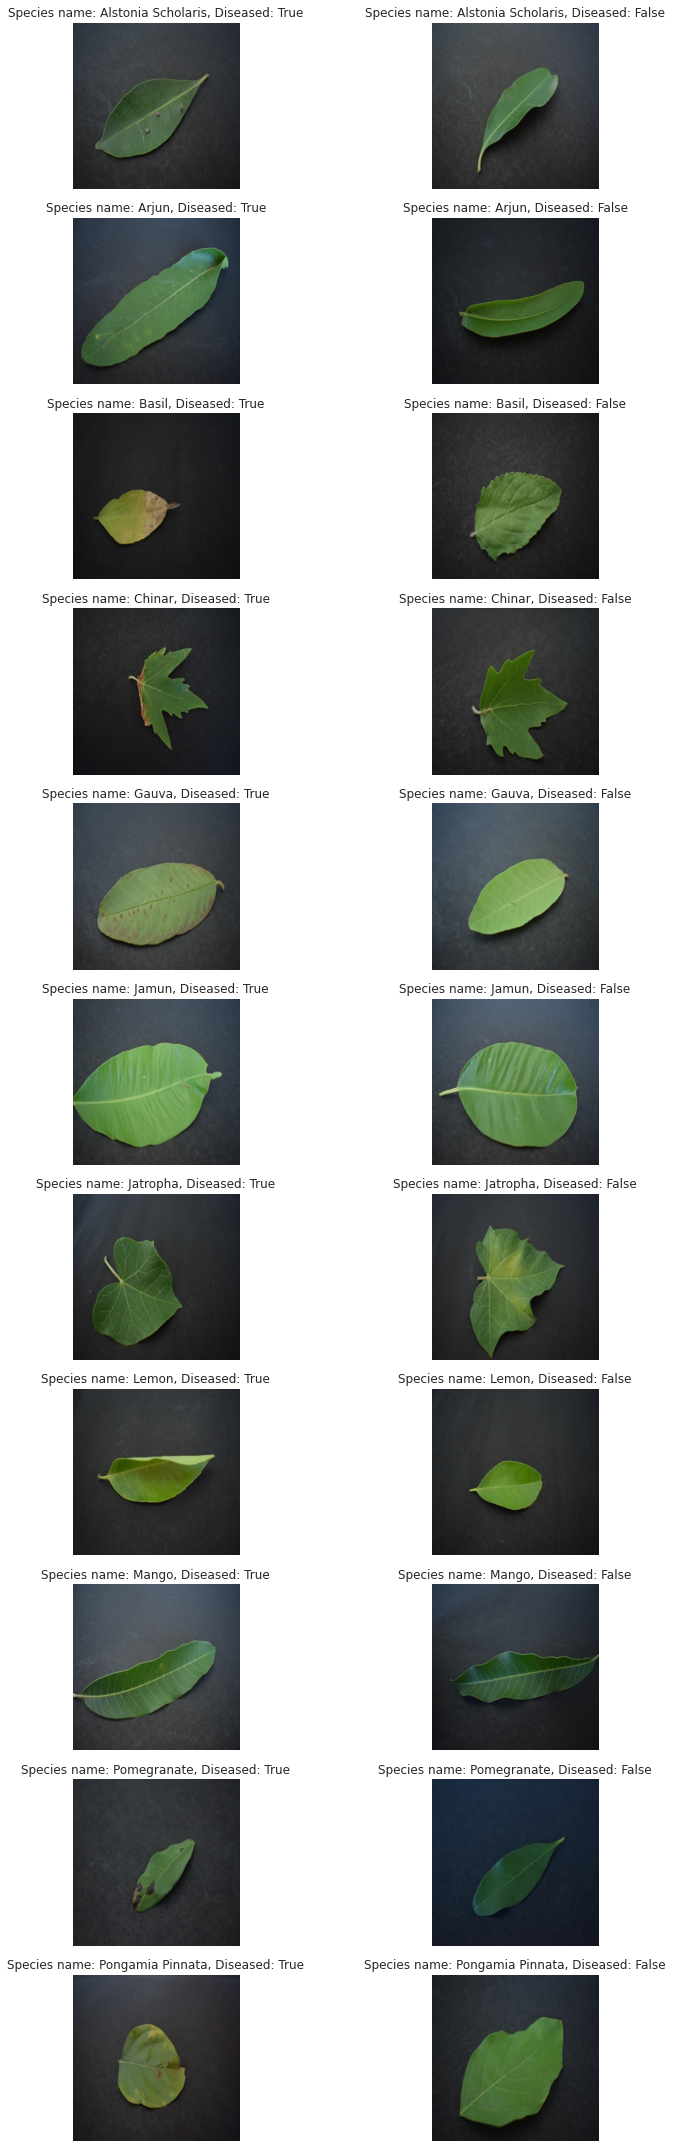

In [21]:
plt: plt.Figure = plot_images_from_metadataframe(
    df=sample_all_df,
    path_col="path",
    subplot_rows=11,
    subplot_cols=2,
    title_cols=["species_name", "diseased"],
    figsize=(13, 30),
)
plt.tight_layout()
plt.show()

---

### 1.4 Decisions
In this section, we will simply highlight some major tasks to consider based on the EDA

* Normalize lopsided distributions (`Lemon`)?
    * We will leave them lopsided for now
* Cap all species samples to a single number? (ex. All species can only have a max of 300 (50-50 diseased) observations)? This may help ensure that certain leaves and their diseases don't monopolize on the model's feature identification
    * We will not cap at the moment, but will refine for future work
* Reorganize `train` and `test` split, to give more `test` data? Perhaps bringing it down from 95% to 75%?
    * The total size of data is minimal so we will stick to the given training and test sets also due to the fact that they are already categorized for us

---

### 1.5 Sampling & Quantization 🧩

[Plotly Reference](https://plotly.com/python/imshow/)


* **Sampling**
    * `Sampling` in the context of image processing involves taking the value of the image at regular spatial intervals. 
    * In layman’s terms, it simply answers the question, *How many cells (pixels) do we want to represent our image?*
    * There would be a plateau-point after which having more pixels delivers the same or worse performance for an ML model


* **Quantization**
    * `Quantization` involves discretizing the intensity values of the analog image. 
    * It is the amount of information per pixel or the image representation per pixel. In simple terms, it is the number of colors with which we can represent the image. It is evident that the more colors we use, the better the representation of our image will be.
    
Sampling and Quantization may be relevant to improve model performance by making certain features standout

Define a utility function to return a random sample of a leaf based on `species name`

In [22]:
def get_image(path: str, engine: Literal["cv", "pillow"] = "pillow") -> np.ndarray:
    if engine == "pillow":
        return np.array(Image.open(path))
    elif engine == "cv":
        return cv2.imread(path)
    else:
        raise ValueError("engine not supported")


def get_image_of_leaf(
    species_name: str, engine: Literal["cv", "pillow"] = "pillow"
) -> np.ndarray | None:
    search_result: pd.DataFrame = sample_species_df[
        sample_species_df["species_name"].str.lower().str.contains(species_name.lower())
    ]
    if search_result.empty:
        raise ValueError("Species not found")
    else:
        return get_image(search_result.iloc[0]["path"], engine=engine)


def list_leaf_species() -> np.ndarray:
    return sample_species_df["species_name"].values

In [23]:
list_leaf_species()

array(['Alstonia Scholaris', 'Arjun', 'Basil', 'Chinar', 'Gauva', 'Jamun',
       'Jatropha', 'Lemon', 'Mango', 'Pomegranate', 'Pongamia Pinnata'],
      dtype=object)

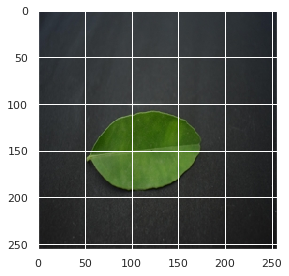

In [27]:
IMG = get_image_of_leaf("lemon")
imshow(IMG)

#### 1.5.1 Histogram Equalization 📉

[Wiki Reference](https://en.wikipedia.org/wiki/Image_histogram)

**About**
* An image histogram is a type of histogram that acts as a graphical representation of the tonal distribution in a digital image. 
* **It plots the number of pixels for each tonal value.**
* By looking at the histogram for a specific image a viewer will be able to judge the entire tonal distribution at a glance.

**Reading the histogram**
* The `left` side of the horizontal axis represents the `dark` areas 
* The `middle` represents `mid-tone` values  
* The `right` hand side represents `light` areas. 
* The `vertical axis` represents the size of the area (`total number of pixels`) that is captured in each one of these zones

In [28]:
IMG_cv: np.ndarray = get_image_of_leaf("lemon", engine="cv")

In [29]:
def compute_histogram_graph(
    hist_data: np.ndarray = None, title: str = None
) -> plt.Figure:
    plt.figure()
    if title:
        plt.title(f"{title} Image Histogram")
    plt.xlabel("Histogram Bins")
    plt.ylabel("Pixel Count")
    if isinstance(hist_data, np.ndarray):
        plt.plot(hist_data)
    plt.xlim([0, 256])
    return plt

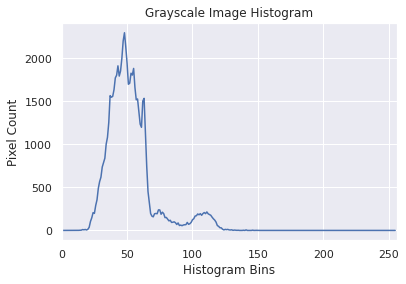

In [30]:
img_cv_gray: np.ndarray = cv2.cvtColor(IMG_cv, cv2.COLOR_BGR2GRAY)

grayscale_hist: np.ndarray = cv2.calcHist(
    images=[img_cv_gray], channels=[0], mask=None, histSize=[256], ranges=[0, 256]
)

plt = compute_histogram_graph(hist_data=grayscale_hist, title="Grayscale")
plt.show()

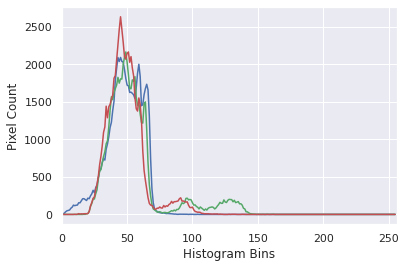

In [31]:
# we use `b`, `g` `r` because opencv reads images as bgr as opposed to rgb
colors: list[str] = ["b", "g", "r"]

plt = compute_histogram_graph()

for indx, color_choice in enumerate(colors):
    color_hist: np.ndarray = cv2.calcHist(
        images=[IMG_cv], channels=[indx], mask=None, histSize=[256], ranges=[0, 256]
    )
    plt.plot(color_hist, color=color_choice)

plt.show()

* Histogram equalization takes the distribution of the histogram and converts it into a `uniform` distribution. 
* This means that parts of the histogram that do not have much tone on the darker side will receive pixel share from the lighter side and vice versa. 
* **Equalization is useful for contrasting the image and making certain features more prominent for machine learning**

In [32]:
def histogram_equalization_algorithm(
    img: np.ndarray | Image.Image,
) -> np.ndarray | None:
    # read image
    image_intensity: np.ndarray = skimage.img_as_ubyte(img)

    # target distirbution: uniform
    freq, bins = skimage.exposure.cumulative_distribution(image_intensity)
    target_bins: np.ndarray = np.arange(255)
    target_freq: np.ndarray = np.linspace(0, 1, len(target_bins))

    # match acual and target bins
    new_vals: np.ndarray = np.interp(freq, target_freq, target_bins)
    try:
        image_eq: np.ndarray = skimage.img_as_ubyte(
            new_vals[image_intensity].astype(int)
        )
    except IndexError:
        print("Unable to enhance image")
        return None

    return image_eq

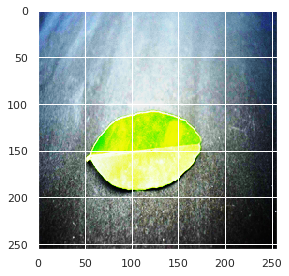

In [33]:
eq_result: np.ndarray | None = histogram_equalization_algorithm(IMG)
imshow(eq_result) if type(eq_result) is np.ndarray else None

✏️ **Notes**
* The background black stands out as a bit more white, which may not be desirable
* The leaf itself grows more brighter
* Another important point to note is that this may not be relevant to the current dataset since it has a black background but could be useful when multiple leaves are present in an image with likey multi color backgrounds.

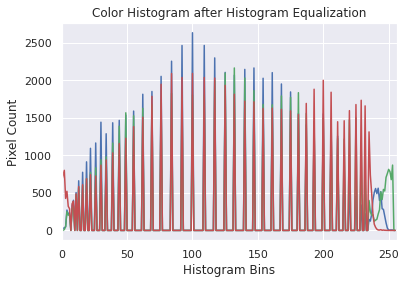

In [34]:
# we use `b`, `g` `r` because opencv reads images as bgr as opposed to rgb
colors: list[str] = ["b", "g", "r"]

plt = compute_histogram_graph()

for indx, color_choice in enumerate(colors):
    color_hist: np.ndarray = cv2.calcHist(
        images=[eq_result], channels=[indx], mask=None, histSize=[256], ranges=[0, 256]
    )
    plt.plot(color_hist, color=color_choice)

plt.title("Color Histogram after Histogram Equalization")
plt.show()

#### 1.5.2 Contrast Stretching 🪢
Similar to `histogram equalization` with some rescaling

In [35]:
def contrast_stretching_algorithm(
    img: np.ndarray | Image.Image, contrast_pct: tuple[int, int] = (2, 90)
) -> np.ndarray | None:
    img_intensity: np.ndarray = skimage.img_as_ubyte(img)

    contrast_img: np.ndarray = skimage.exposure.rescale_intensity(
        img_intensity, in_range=tuple(np.percentile(img_intensity, contrast_pct))
    )
    return contrast_img

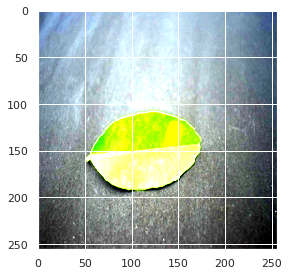

In [36]:
contrast_result: np.ndarray | None = contrast_stretching_algorithm(IMG)
imshow(contrast_result) if type(contrast_result) is np.ndarray else None

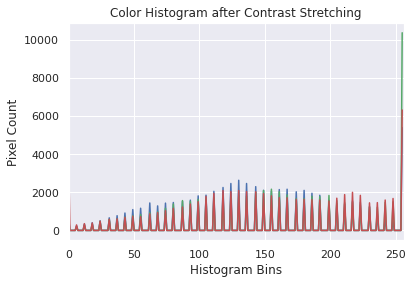

In [37]:
# we use `b`, `g` `r` because opencv reads images as bgr as opposed to rgb
colors: list[str] = ["b", "g", "r"]

plt = compute_histogram_graph()

for indx, color_choice in enumerate(colors):
    color_hist: np.ndarray = cv2.calcHist(
        images=[contrast_result],
        channels=[indx],
        mask=None,
        histSize=[256],
        ranges=[0, 256],
    )
    plt.plot(color_hist, color=color_choice)

plt.title("Color Histogram after Contrast Stretching")
plt.show()

#### 1.5.3 Edge Detection 🌄

* Edge detection is important for traning the machine learning model
* Not only has to discover the leaf but also the artefacts on the leaf to identify the disease

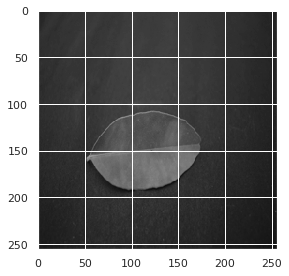

In [38]:
bw_image: np.ndarray = skimage.color.rgb2gray(IMG)
imshow(bw_image)

In [39]:
def get_bw_edges(
    img: np.ndarray | Image.Image, edge_kernel: np.ndarray = None
) -> np.ndarray | None:
    # convert image to numpy array if it's not already
    img: np.ndarray = np.array(img) if not isinstance(img, np.ndarray) else img

    # convert to black and white if input is RGB
    img_bw = None
    if len(img.shape) == 3:
        img_bw: np.ndarray = skimage.color.rgb2gray(img)
    elif len(img.shape) == 2:
        img_bw = img

    # use custom edge detection mask / kernel if not specified
    edge: np.ndarray = (
        np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
        if not edge_kernel
        else edge_kernel
    )

    return scipy.signal.convolve2d(img_bw, edge, mode="valid")

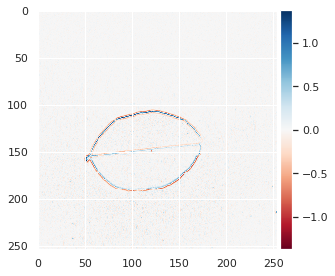

In [40]:
imshow(get_bw_edges(IMG))

**Notes ✏️**
* The shape of the leaf is clear with the major vein showing up for different species
* Some noise still exists in the background
* Looks more useful for detecting leaves as opposed to the diseases

In [41]:
def sharpen(img: np.ndarray | Image.Image) -> np.ndarray | None:
    # convert image to numpy array if it's not already
    img = np.array(img) if not isinstance(img, np.ndarray) else img

    # convert to black and white if input is RGB
    img_bw = None
    if len(img.shape) == 3:
        img_bw: np.ndarray = skimage.color.rgb2gray(img)
    elif len(img.shape) == 2:
        img_bw = img

    # use a custom sharpening mask
    sharpen_matrix: np.ndarray = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return scipy.signal.convolve2d(img_bw, sharpen_matrix, mode="valid")

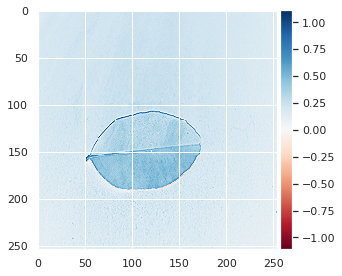

In [42]:
sharpened_image: np.ndarray = sharpen(IMG)
imshow(sharpened_image)

**✏️ Notes**
* The sharpened image shows the edges on the inner side of the leaf much better
* Looks more ideal for leaf disease detection

#### 1.5.4 Function Composition 🌀

In [43]:
# define a function to sharpen and then get edges
sharpen_edges: Callable[np.ndarray, np.ndarray | None] = lambda img: get_bw_edges(
    sharpen(img)
)

# define a function to contrast the image, sharpen and then get edges
sharpen_contrasted_edges: Callable[
    np.ndarray, np.ndarray | None
] = lambda img: sharpen_edges(contrast_stretching_algorithm(img))

Sharpened Edges


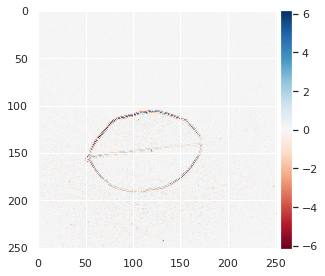

In [44]:
sharpened_edges: np.ndarray = sharpen_edges(IMG)
print("Sharpened Edges")
imshow(sharpened_edges)

Contrasted Sharpened Edges


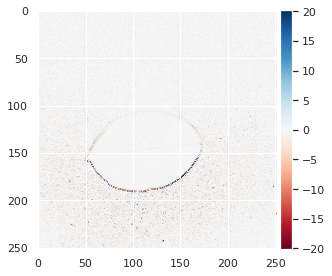

In [45]:
sharp_contrast_edges: np.ndarray = sharpen_contrasted_edges(IMG)
print("Contrasted Sharpened Edges")
imshow(sharp_contrast_edges)

**✏️ Notes**

* Using `contrast stretching` loses the edge features within the leaf so may not be ideal for disease detection
* `sharpened edges` seems desirable as a minimal set of features that completely descirbes the leaf structure as well as any diseases

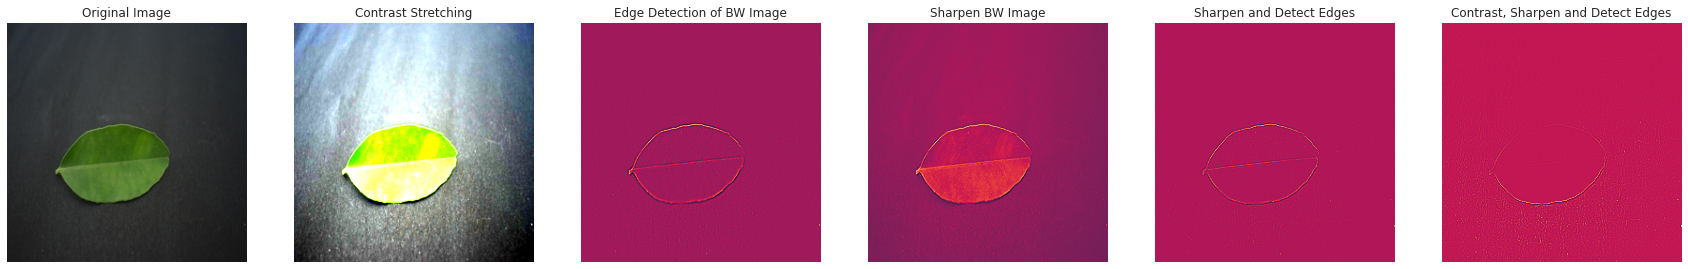

In [46]:
# create mapping between names (titles) and their respective algo function callables declared previously
img_op_algos: list[tuple[str, Callable | None]] = [
    ("Original Image", None),
    ("Contrast Stretching", contrast_stretching_algorithm),
    ("Edge Detection of BW Image", get_bw_edges),
    ("Sharpen BW Image", sharpen),
    ("Sharpen and Detect Edges", sharpen_edges),
    ("Contrast, Sharpen and Detect Edges", sharpen_contrasted_edges),
]

# display all results in a single-grid row
subplot_rows: int = 1
subplot_cols: int = len(img_op_algos)
fig = plt.figure(figsize=(30, 9))

for indx, algo in enumerate(img_op_algos):
    # unpack tuple containing name and algorithm
    algo_id, algo_fn = algo

    fig.add_subplot(subplot_rows, subplot_cols, indx + 1)

    # no function on original image
    img_result: np.ndarray = algo_fn(IMG) if (indx + 1) > 1 else IMG

    plt.imshow(img_result)
    plt.axis("off")
    plt.title(algo_id)

plt.show()

---

### 1.6 Object Detection 🔍

* Detecting the leaf object and the disease artefacts in different images
* Useful for identifying point of interest within the image, especially for cases where there may be multiple leaves in an image

#### 1.6.1 Binary Threshold (Manual) 🐼

**About**
* Image binarization is used to convert RGB images to binary colors to accentuate edges
* Note that grayscale and binary images are not the same
* We convert the images to grayscale and then try different steps of binary threshold sequences to see if edges get detected

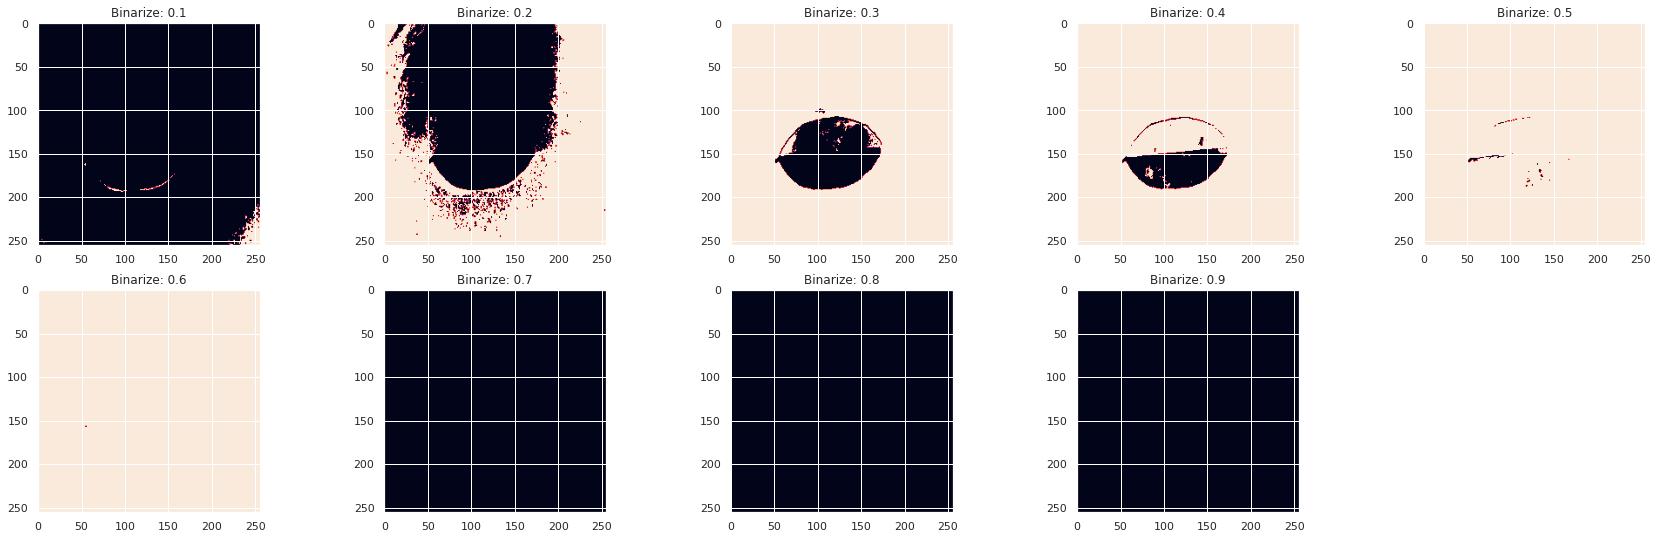

In [47]:
bw_image = skimage.color.rgb2gray(IMG)
subplot_rows: int = 2
subplot_cols: int = 5

fig = plt.figure(figsize=(30, 9))

for val in range(1, 10):
    fig.add_subplot(subplot_rows, subplot_cols, val)
    img_result: np.ndarray = bw_image < (val / 10)
    plt.imshow(img_result)
    plt.title(f"Binarize: {val / 10}")

plt.show()

**✏️ Notes**
* The binarize threshold is variable based on the kind of leaf
* Very low and high values result in full white or black which can be clipped

#### 1.6.2 Binary Threshold (Auto) 🦓

[Wiki Reference](https://en.wikipedia.org/wiki/Otsu%27s_method)

* We instead use an `automatic threshold` generating algorithm called `Otsu's method`
* It returns a single intensity threshold that separates the pixels into `two classes`
* The classes are broadly understood as `foreground` and `background`
* Equivalent to `k-means for images`

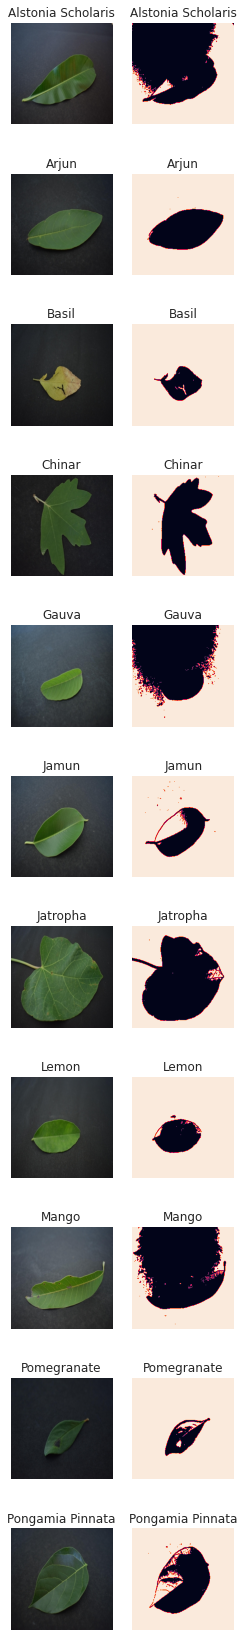

In [48]:
all_species: np.ndarray = list_leaf_species()
subplot_rows: int = int(len(all_species))
subplot_cols: int = 2

fig = plt.figure(figsize=(4, 30))

for indx, sp in zip([x for x in range(1, len(all_species) * 2, 2)], all_species):
    img_sample: np.ndarray = get_image_of_leaf(sp)
    bw_img_sample: np.ndarray = skimage.color.rgb2gray(img_sample)
    binary_threshold_otsu: float = skimage.filters.threshold_otsu(bw_img_sample)
    img_result: np.ndarray = bw_img_sample < binary_threshold_otsu

    fig.add_subplot(subplot_rows, subplot_cols, indx)
    plt.imshow(img_sample)
    plt.title(sp)
    plt.axis("off")

    fig.add_subplot(subplot_rows, subplot_cols, indx + 1)
    plt.imshow(img_result)
    plt.title(sp)
    plt.axis("off")

plt.show()

**✏️ Notes**
* Otsu's method and binarization is useful for detecting in-leaf artefacts as well as easily separating the image from the background as well as highlight granules on the leaf surface.
* There are a small fraction of false positives in terms of edges such as `mango`

**Other Trials**:
* Using `sharpen` had no effect on the false positives
* `sharpen_edges` and `sharpen_contrasted_edges` was undetectable by Otsu's algorithm

#### 1.6.3 Color Segmentation 🎨

* Making the color of the leaf stand out compared to the background can be useful for detecting leaf and non-leaf objects
* We use HSV (Hue, Saturation & Value) transformation to achieve this
* The color we need (ex. green) can then be filtered out from the image matrix resulting in segmentation

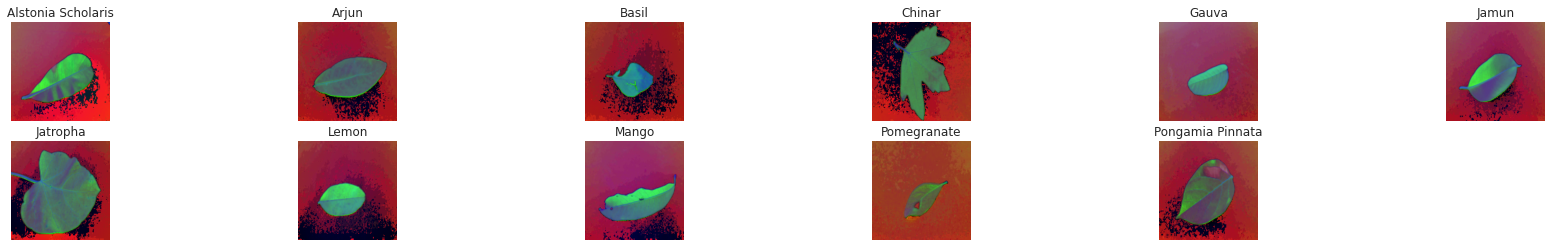

In [50]:
all_species: np.ndarray = list_leaf_species()
subplot_rows: int = 2
subplot_cols: int = int(len(all_species) / 2) + 1

fig = plt.figure(figsize=(30, 4))

for indx, sp in enumerate(all_species):
    img_sample: np.ndarray = get_image_of_leaf(sp)
    hsv_img_sample: np.ndarray = skimage.color.rgb2hsv(np.array(img_sample))

    fig.add_subplot(subplot_rows, subplot_cols, indx + 1)
    plt.imshow(hsv_img_sample)
    plt.title(sp)
    plt.axis("off")

plt.show()

#### 1.6.4 Image Dilation 🪗

Here we attempt to morph the image in order to see if features can be extracted

In [51]:
def dilate(img: np.ndarray, num_dilations: int = 5) -> np.ndarray:
    """
    Image dilation
    """
    for _ in range(num_dilations):
        img = skimage.morphology.dilation(img)
    return img


def area_close(img: np.ndarray, num_closes: int = 41) -> np.ndarray:
    """
    Removes dark structures
    """
    for _ in range(num_closes):
        img = skimage.morphology.area_closing(img)
    return img


def enhanced_image_morph(
    img: np.ndarray, dil: int = 5, clo: int = 41, med: int = 21
) -> np.ndarray:
    # median filter removes noise
    return scipy.ndimage.median_filter(
        area_close(dilate(img, num_dilations=dil), num_closes=clo), size=med
    )

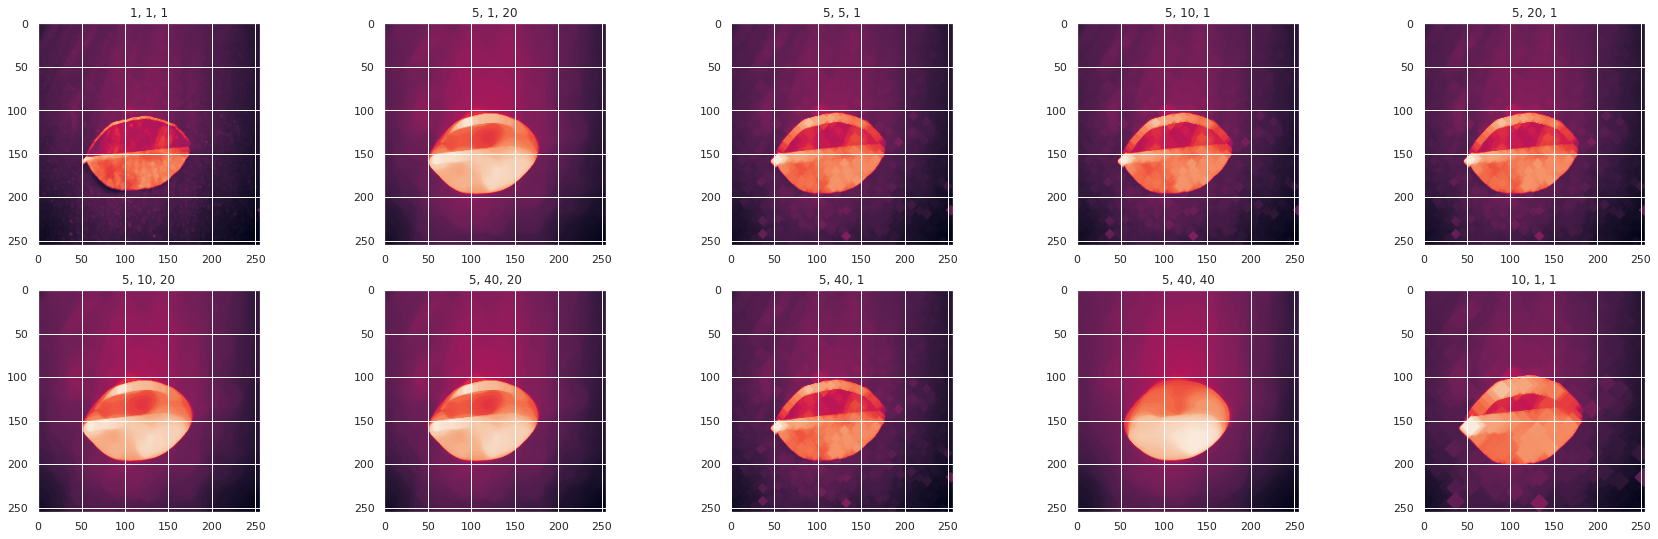

In [52]:
tweak_morph_params: list[tuple[int, int, int]] = [
    (1, 1, 1),
    (5, 1, 20),
    (5, 5, 1),
    (5, 10, 1),
    (5, 20, 1),
    (5, 10, 20),
    (5, 40, 20),
    (5, 40, 1),
    (5, 40, 40),
    (10, 1, 1),
]

subplot_rows: int = 2
subplot_cols: int = 5

fig = plt.figure(figsize=(30, 9))

for indx, params in enumerate(tweak_morph_params):
    dil_param, area_param, median_param = params
    fig.add_subplot(subplot_rows, subplot_cols, indx + 1)
    img_result: np.ndarray = enhanced_image_morph(
        bw_image, dil_param, area_param, median_param
    )
    plt.imshow(img_result)
    plt.title(f"{dil_param}, {area_param}, {median_param}")

plt.show()

**✏️ Notes**
* Morphing loses the leaf disease details and is otherwise not useful without more background artefacts

---

### 1.7 Color Study 🎨

We can also explore the distirbution of color values on a 3d RGB plot with sides `256 x 256 x 256`

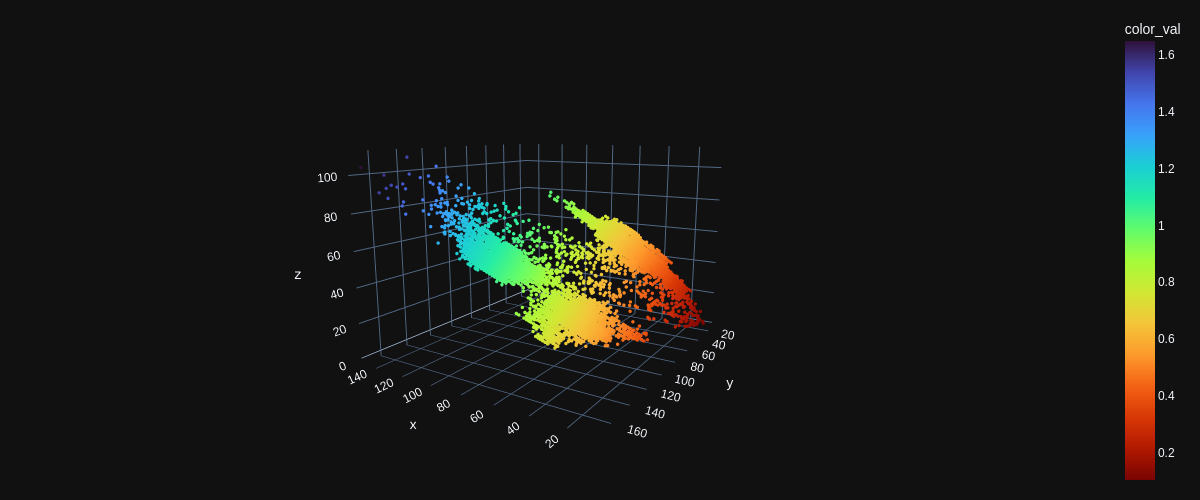

In [53]:
x, y, z, c = [], [], [], []
pixel_access = Image.fromarray(IMG).load()

for row in range(Image.fromarray(IMG).height):
    for col in range(Image.fromarray(IMG).width):
        pix = pixel_access[col, row]
        new_col = (pix[0] / 255, pix[1] / 255, pix[2] / 255)

        if new_col not in c:
            x.append(pix[0])
            y.append(pix[1])
            z.append(pix[2])
            c.append(new_col)

color_df = pd.DataFrame(
    data=[(xx, yy, zz, cc[0], cc[1], cc[2]) for xx, yy, zz, cc in zip(x, y, z, c)],
    columns=["x", "y", "z", "color_r", "color_g", "color_b"],
)

color_df["color_val"] = color_df["color_r"] + color_df["color_g"] + color_df["color_b"]

fig = px.scatter_3d(
    color_df,
    x=x,
    y=y,
    z=z,
    color="color_val",
    template="plotly_dark",
    color_continuous_scale=px.colors.sequential.Turbo_r,
)
fig.update_traces(marker_size=2)
fig.update_layout(margin=dict(l=10, r=10, b=10, t=10), width=1200, height=500)

fig.update_layout(scene_camera_eye=dict(x=-1.25, y=2, z=0.5))
# fig.show("plotly_mimetype+notebook")  # use this arg 'plotly_mimetype+notebook' for interactive plot
fig.show("png")